In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
#import qi
import time
datapath = 'data/'

WHISTLE_BUFF_LEN = 1024
WHISTLE_FFT_LEN = 2 * WHISTLE_BUFF_LEN
SOUND_LIMIT = 15000
SILENCE_LIMIT = 1000
SEQ_LIMIT = 1000
SAMPLE_NUMBER = 40000

# Data processing


# Load audio

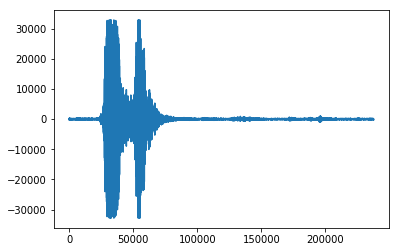

In [2]:
fs, data = wavfile.read(datapath + '2.wav') 
plt.plot(data)

## Extract positive segments (with whistle)

In [3]:
pos_segments = []

In [4]:
def broad_right(sample):
    last_seen = 0
    for i in range(len(sample)):
        if sample[i]:
            last_seen = SEQ_LIMIT
        else:
            last_seen -= 1
            
        if last_seen > 0:
            sample[i] = True
        
    return sample

def getZones(b_sample):
    l, r = 0, 0
    res = []
    
    for i in range(1, len(b_sample)):
        if b_sample[i - 1] and not b_sample[i]:
            res.append((l, i-1))
            continue
        
        if not b_sample[i - 1] and b_sample[i]:
            l = i
    if b_sample[-1]:
        res.append((l, len(b_sample) - 1))
        
    return res

In [5]:
A = (np.abs(data) > SOUND_LIMIT)
A = broad_right(A)
A = broad_right(A[::-1])[::-1]
pos_segments = getZones(A)

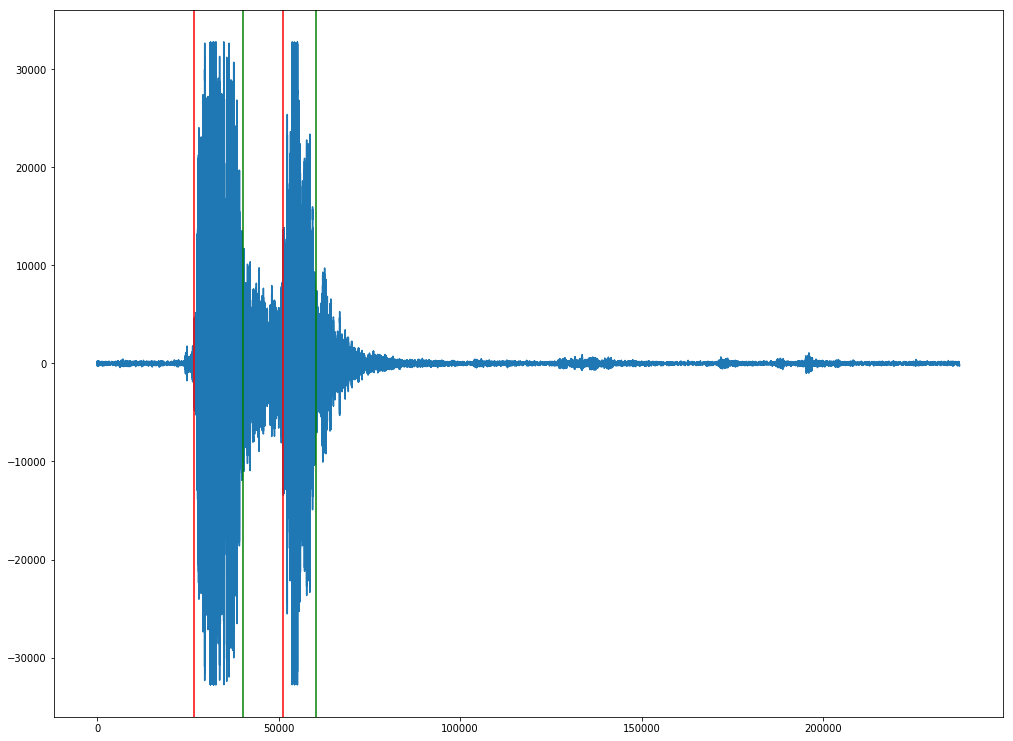

In [6]:
plt.figure(figsize=(17, 13))
plt.plot(data)
for l, r in pos_segments:
    plt.axvline(l, color='red')
    plt.axvline(r, color='green')

## Extract negative segments (without whistle)

In [7]:
neg_segments = []

In [8]:
B = (np.abs(data) > SILENCE_LIMIT)
B = broad_right(B)
B = broad_right(B[::-1])[::-1]
neg_segments = getZones(1 - B)

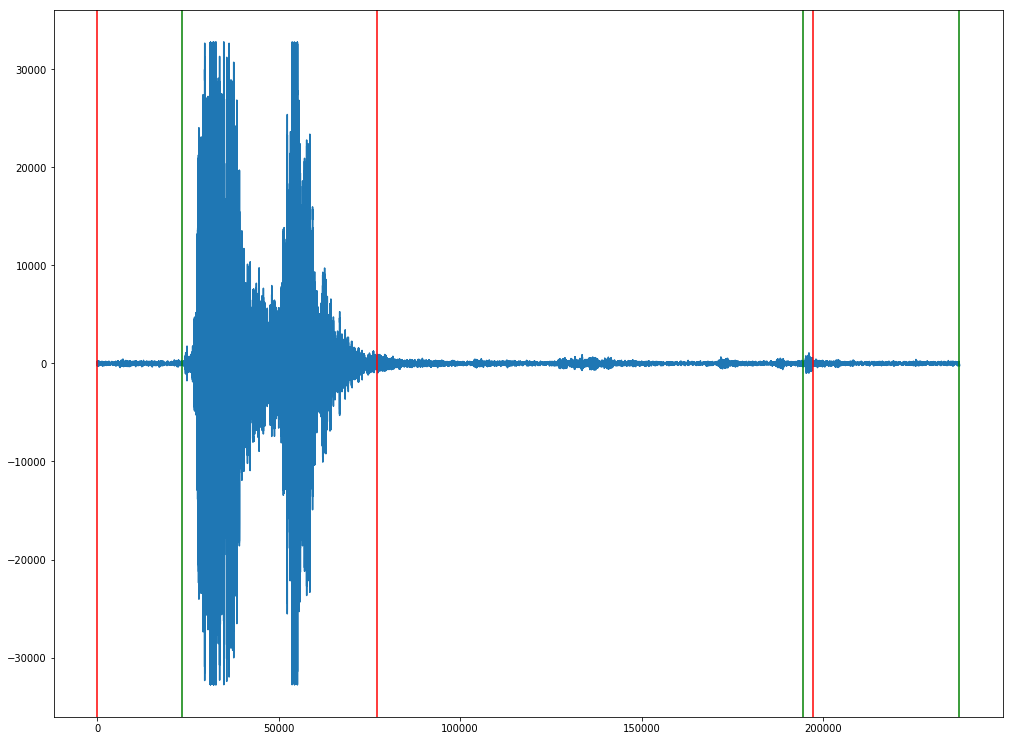

In [9]:
plt.figure(figsize=(17, 13))
plt.plot(data)
for l, r in neg_segments:
    plt.axvline(l, color='red')
    plt.axvline(r, color='green')

## augmentation of this segments (dividing into segments with size WHISTLE_FFT_LEN)

In [10]:
from random import randrange
def rand_crop(sample):
    N = len(sample)
    l = randrange(N - WHISTLE_FFT_LEN + 1)
    return sample[l : l + WHISTLE_FFT_LEN]

def make_samples(data_indexes_list, N):
    res = []
    for i in range(N):
        ind = randrange(len(data_indexes_list))
        l, r = data_indexes_list[ind]
        res.append(rand_crop(data[l : r]))
        
    return res

In [11]:
pos_segments

[(26797, 40239), (51340, 60374)]

In [12]:
X = np.array(make_samples(pos_segments, SAMPLE_NUMBER // 2) + make_samples(neg_segments, SAMPLE_NUMBER // 2))
y = np.hstack((np.ones(SAMPLE_NUMBER // 2), np.zeros(SAMPLE_NUMBER // 2)))
print(X.shape, y.shape)

(40000, 2048) (40000,)



# Learning logistic legression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [14]:
def get_optimizer(X, y, **kvargs):
    param_grid = {'C': [ 0.1, 0.5], 
                 'penalty': ['l1', 'l2']}
    cv = 3
    
    lr_mean =  LogisticRegression(**kvargs)
    optimizer = GridSearchCV(lr_mean, param_grid, cv=cv)
    optimizer.fit(X, y)
    return optimizer

In [15]:
(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=0,
                                    shuffle=True)

In [16]:
X_train.shape

(28000, 2048)

In [ ]:
best_opt = get_optimizer(X_train, y_train)

print("Score on test is {} - with C={}".format(optimizer_mean.score(X_test, y_test),
                                                          optimizer_mean.best_params_['C']))

/home/asus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
